In [1]:

import math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.neighbors import NearestNeighbors

torch.set_float32_matmul_precision("high")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)


In [2]:
# %% Swiss roll parametric map and data gen
# phi(u, v) -> (x, y, z)
def swiss_phi(u, v):
    # u, v: (...,) tensors
    x = u * torch.cos(u)
    y = v
    z = u * torch.sin(u)
    return torch.stack([x, y, z], dim=-1)

def sample_swiss_intrinsic(N, u_min=1.5*math.pi, u_max=4.5*math.pi, v_min=0.0, v_max=10.0, seed=None):
    if seed is not None:
        g = torch.Generator().manual_seed(seed)
        u = torch.empty(N).uniform_(u_min, u_max, generator=g)
        v = torch.empty(N).uniform_(v_min, v_max, generator=g)
    else:
        u = torch.empty(N).uniform_(u_min, u_max)
        v = torch.empty(N).uniform_(v_min, v_max)
    uv = torch.stack([u, v], dim=-1)  # (N, 2)
    xyz = swiss_phi(u, v)             # (N, 3)
    return uv, xyz

# small train/val/test
N_train, N_val, N_test = 4000, 1000, 1000
uv_train, x_train = sample_swiss_intrinsic(N_train, seed=1)
uv_val,   x_val   = sample_swiss_intrinsic(N_val,   seed=2)
uv_test,  x_test  = sample_swiss_intrinsic(N_test,  seed=3)

uv_train, x_train = uv_train.to(device), x_train.to(device)
uv_val,   x_val   = uv_val.to(device),   x_val.to(device)
uv_test,  x_test  = uv_test.to(device),  x_test.to(device)


In [3]:
# %% Noise schedule (continuous time t in [0,1]) -> sigma(t)
def sigma_t(t):
    # simple linear schedule; feel free to try cosine
    return 0.01 + 0.99 * t

def sample_timesteps(B):
    return torch.rand(B, device=device)  # Uniform[0,1]

def add_euclidean_noise(x0, t):
    # x0: (B,3), t: (B,)
    sig = sigma_t(t).unsqueeze(-1)  # (B,1)
    eps = torch.randn_like(x0)
    x_t = x0 + sig * eps
    return x_t, eps, sig

def add_intrinsic_noise(uv0, t):
    # uv0: (B,2), t: (B,)
    sig = sigma_t(t).unsqueeze(-1)
    xi  = torch.randn_like(uv0)
    uv_t = uv0 + sig * xi
    return uv_t, xi, sig


In [4]:
# %% Tiny MLPs with time conditioning
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, out_dim),
        )
    def forward(self, x):
        return self.net(x)

class TimeCondScore(nn.Module):
    """ Concatenate (x, t_emb) then predict noise """
    def __init__(self, xdim, out_dim, hidden=128):
        super().__init__()
        self.t_embed = nn.Sequential(nn.Linear(1, hidden//2), nn.SiLU(), nn.Linear(hidden//2, hidden//2))
        self.core = MLP(xdim + hidden//2, out_dim, hidden)
    def forward(self, x, t):
        t = t.view(-1,1)
        te = self.t_embed(t)
        return self.core(torch.cat([x, te], dim=-1))


In [5]:
# %% Euclidean DSM training loop (3D)
def train_euclidean_dsm(x_train, x_val, epochs=20, batch=256, lr=2e-3):
    model = TimeCondScore(xdim=3, out_dim=3, hidden=128).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    ds = TensorDataset(x_train)
    dl = DataLoader(ds, batch_size=batch, shuffle=True, drop_last=True)
    best_val = float("inf"); best = None

    for ep in range(1, epochs+1):
        model.train(); losses=[]
        for (x0_batch,) in dl:
            B = x0_batch.size(0)
            t = sample_timesteps(B)
            x_t, eps, sig = add_euclidean_noise(x0_batch, t)
            pred = model(x_t, t)             # predict noise
            loss = F.mse_loss(pred, eps)     # DSM loss
            opt.zero_grad(); loss.backward(); opt.step()
            losses.append(loss.item())

        # quick val loss (noise prediction MSE) on a random subset
        model.eval()
        with torch.no_grad():
            idx = torch.randperm(x_val.size(0), device=device)[:2048]
            xv = x_val[idx]
            tv = sample_timesteps(xv.size(0))
            x_tv, eps_v, _ = add_euclidean_noise(xv, tv)
            val_loss = F.mse_loss(model(x_tv, tv), eps_v).item()

        if val_loss < best_val:
            best_val = val_loss; best = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        print(f"[Eucl] ep {ep:02d} | train {np.mean(losses):.4f} | val {val_loss:.4f}")

    if best is not None:
        model.load_state_dict(best)
    return model

eucl_model = train_euclidean_dsm(x_train, x_val, epochs=20)


[Eucl] ep 01 | train 1.0160 | val 1.0157
[Eucl] ep 02 | train 1.0138 | val 1.0123
[Eucl] ep 03 | train 1.0035 | val 0.9904
[Eucl] ep 04 | train 0.9996 | val 0.9870
[Eucl] ep 05 | train 0.9800 | val 0.9475
[Eucl] ep 06 | train 0.9999 | val 1.0002
[Eucl] ep 07 | train 0.9647 | val 0.9927
[Eucl] ep 08 | train 0.9643 | val 0.9988
[Eucl] ep 09 | train 0.9781 | val 0.9652
[Eucl] ep 10 | train 0.9816 | val 0.9859
[Eucl] ep 11 | train 0.9704 | val 0.9814
[Eucl] ep 12 | train 0.9816 | val 0.9947
[Eucl] ep 13 | train 0.9837 | val 1.0040
[Eucl] ep 14 | train 0.9818 | val 1.0098
[Eucl] ep 15 | train 0.9822 | val 0.9686
[Eucl] ep 16 | train 0.9565 | val 0.9413
[Eucl] ep 17 | train 0.9579 | val 1.0057
[Eucl] ep 18 | train 0.9884 | val 0.9509
[Eucl] ep 19 | train 0.9788 | val 0.9817
[Eucl] ep 20 | train 0.9654 | val 0.9408


In [6]:
# %% Intrinsic DSM training loop (2D)
def train_intrinsic_dsm(uv_train, uv_val, epochs=20, batch=256, lr=2e-3):
    model = TimeCondScore(xdim=2, out_dim=2, hidden=128).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    ds = TensorDataset(uv_train)
    dl = DataLoader(ds, batch_size=batch, shuffle=True, drop_last=True)
    best_val = float("inf"); best=None

    for ep in range(1, epochs+1):
        model.train(); losses=[]
        for (uv0_batch,) in dl:
            B = uv0_batch.size(0)
            t = sample_timesteps(B)
            uv_t, xi, sig = add_intrinsic_noise(uv0_batch, t)
            pred = model(uv_t, t)
            loss = F.mse_loss(pred, xi)  # DSM loss in intrinsic coords
            opt.zero_grad(); loss.backward(); opt.step()
            losses.append(loss.item())

        # quick val
        model.eval()
        with torch.no_grad():
            idx = torch.randperm(uv_val.size(0), device=device)[:2048]
            uvv = uv_val[idx]
            tv = sample_timesteps(uvv.size(0))
            uv_tv, xi_v, _ = add_intrinsic_noise(uvv, tv)
            val_loss = F.mse_loss(model(uv_tv, tv), xi_v).item()

        if val_loss < best_val:
            best_val = val_loss; best = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        print(f"[Manif] ep {ep:02d} | train {np.mean(losses):.4f} | val {val_loss:.4f}")

    if best is not None:
        model.load_state_dict(best)
    return model

manif_model = train_intrinsic_dsm(uv_train, uv_val, epochs=20)


[Manif] ep 01 | train 0.9591 | val 0.9446
[Manif] ep 02 | train 0.9782 | val 0.9313
[Manif] ep 03 | train 0.9822 | val 0.9477
[Manif] ep 04 | train 0.9851 | val 0.9906
[Manif] ep 05 | train 0.9752 | val 0.9519
[Manif] ep 06 | train 0.9792 | val 1.0111
[Manif] ep 07 | train 0.9978 | val 0.9437
[Manif] ep 08 | train 0.9956 | val 0.9697
[Manif] ep 09 | train 0.9642 | val 0.9654
[Manif] ep 10 | train 0.9710 | val 0.9389
[Manif] ep 11 | train 0.9663 | val 0.9837
[Manif] ep 12 | train 0.9694 | val 0.9916
[Manif] ep 13 | train 0.9610 | val 0.9780
[Manif] ep 14 | train 0.9841 | val 0.9843
[Manif] ep 15 | train 0.9533 | val 0.9577
[Manif] ep 16 | train 0.9455 | val 0.9747
[Manif] ep 17 | train 0.9707 | val 0.9120
[Manif] ep 18 | train 0.9442 | val 0.9876
[Manif] ep 19 | train 0.9538 | val 0.9591
[Manif] ep 20 | train 0.9804 | val 0.9411


In [7]:
# %% Simple reverse-time sampling (toy Euler steps)
@torch.no_grad()
def sample_euclidean(model, n=1000, steps=50):
    # start from Gaussian noise in R^3 roughly matching data scale
    x = torch.randn(n, 3, device=device) * 5.0
    for s in reversed(range(steps)):
        t = torch.full((n,), (s+0.5)/steps, device=device)
        sig = sigma_t(t).unsqueeze(-1)
        score = model(x, t)  # predicts noise ~ epsilon
        # reverse SDE step (toy): x <- x - sig^2 * score + sqrt(dt)*noise
        dt = 1.0/steps
        x = x - (sig**2) * score * dt + torch.randn_like(x) * math.sqrt(dt) * sig.mean()
    return x

@torch.no_grad()
def sample_manifold(model, n=1000, steps=50, u_min=1.5*math.pi, u_max=4.5*math.pi, v_min=0.0, v_max=10.0):
    # start from uniform (or Gaussian) prior in (u,v)
    u0 = torch.empty(n, device=device).uniform_(u_min, u_max)
    v0 = torch.empty(n, device=device).uniform_(v_min, v_max)
    uv = torch.stack([u0, v0], dim=-1)
    for s in reversed(range(steps)):
        t = torch.full((n,), (s+0.5)/steps, device=device)
        sig = sigma_t(t).unsqueeze(-1)
        score = model(uv, t)  # predicts intrinsic noise
        dt = 1.0/steps
        uv = uv - (sig**2) * score * dt + torch.randn_like(uv) * math.sqrt(dt) * sig.mean()
        # (optional) clamp to parameter ranges
        uv[:,0] = uv[:,0].clamp(u_min, u_max)
        uv[:,1] = uv[:,1].clamp(v_min, v_max)
    x = swiss_phi(uv[:,0], uv[:,1])
    return x, uv

# Generate samples
x_samp_eucl = sample_euclidean(eucl_model, n=2000, steps=75)
x_samp_manif, uv_samp_manif = sample_manifold(manif_model, n=2000, steps=75)


In [8]:
# %% Off-manifold residual δ(x): distance to the roll constraint
@torch.no_grad()
def off_manifold_delta(x):
    # x: (N,3)
    r = torch.sqrt(x[:,0]**2 + x[:,2]**2)      # radius in xz-plane
    a = torch.atan2(x[:,2], x[:,0])            # angle
    # match r ~ a + 2πk; pick nearest k to r-a
    k = torch.round((r - a) / (2*math.pi))
    delta = torch.abs(r - (a + 2*math.pi*k))
    return delta

def off_manifold_percent(x, tau=1e-2):
    d = off_manifold_delta(x)
    return (d > tau).float().mean().item()

# %% k-NN overlap: compare neighborhood structure via uv-space
def knn_overlap(uv_real, uv_gen, k=10, sample=1000, seed=0):
    rng = np.random.default_rng(seed)
    idx = rng.choice(uv_gen.shape[0], size=min(sample, uv_gen.shape[0]), replace=False)
    uvR = uv_real.detach().cpu().numpy()
    uvG = uv_gen.detach().cpu().numpy()
    nbrs = NearestNeighbors(n_neighbors=k, algorithm="auto").fit(uvR)
    # for each generated point, find nearest real anchor then compare neighborhoods
    overlaps = []
    for j in idx:
        g = uvG[j:j+1]
        # anchor real point (nearest in uv)
        ir = NearestNeighbors(n_neighbors=1).fit(uvR).kneighbors(g, return_distance=False)[0,0]
        # kNN of anchor among real
        R_idx = nbrs.kneighbors(uvR[ir:ir+1], return_distance=False).ravel()
        # kNN of generated point among real
        G_idx = nbrs.kneighbors(g, return_distance=False).ravel()
        inter = len(set(R_idx).intersection(set(G_idx)))
        union = len(set(R_idx).union(set(G_idx)))
        overlaps.append(inter/union)
    return float(np.mean(overlaps))

# %% MMD (RBF kernel)
def _rbf_kernel(x, y, gamma):
    # x:(N,D), y:(M,D)
    x2 = (x**2).sum(-1, keepdims=True)
    y2 = (y**2).sum(-1, keepdims=True).T
    xy = x @ y.T
    dist2 = x2 + y2 - 2*xy
    return torch.exp(-gamma * dist2)

@torch.no_grad()
def mmd_rbf(x_real, x_gen, gammas=(0.05, 0.2, 1.0)):
    xr = x_real
    xg = x_gen
    m = xr.size(0); n = xg.size(0)
    # subsample to balance
    m0 = min(m, 2000); n0 = min(n, 2000)
    idxr = torch.randperm(m, device=device)[:m0]
    idxg = torch.randperm(n, device=device)[:n0]
    xr = xr[idxr]; xg = xg[idxg]

    mmd = 0.0
    for g in gammas:
        Krr = _rbf_kernel(xr, xr, g); Krg = _rbf_kernel(xr, xg, g); Kgg = _rbf_kernel(xg, xg, g)
        # unbiased estimate
        mask_r = ~torch.eye(Krr.size(0), dtype=bool, device=device)
        mask_g = ~torch.eye(Kgg.size(0), dtype=bool, device=device)
        term = Krr[mask_r].mean() + Kgg[mask_g].mean() - 2*Krg.mean()
        mmd += term
    return (mmd / len(gammas)).item()


In [9]:
# %% Evaluate
with torch.no_grad():
    off_eucl  = off_manifold_percent(x_samp_eucl, tau=1e-2)
    off_manif = off_manifold_percent(x_samp_manif, tau=1e-2)

    # For kNN overlap and MMD, compare to test set
    # (Intrinsic uv for manifold samples is already available; for euclidean, map to nearest uv via projection — here we omit and only report manifold knn overlap.)
    knn_ov_manif = knn_overlap(uv_test, uv_samp_manif, k=10, sample=800)

    # MMD in 3D space (you can also do in uv)
    mmd_eucl  = mmd_rbf(x_test, x_samp_eucl)
    mmd_manif = mmd_rbf(x_test, x_samp_manif)

print(f"Off-manifold % (lower is better): Euclidean={100*off_eucl:.2f}% | Manifold={100*off_manif:.2f}%")
print(f"kNN Jaccard overlap (manifold samples vs real uv): {knn_ov_manif:.3f}  (higher is better)")
print(f"MMD-RBF (3D) (lower is better): Euclidean={mmd_eucl:.4f} | Manifold={mmd_manif:.4f}")


Off-manifold % (lower is better): Euclidean=99.65% | Manifold=0.00%
kNN Jaccard overlap (manifold samples vs real uv): 0.740  (higher is better)
MMD-RBF (3D) (lower is better): Euclidean=0.0284 | Manifold=0.0001


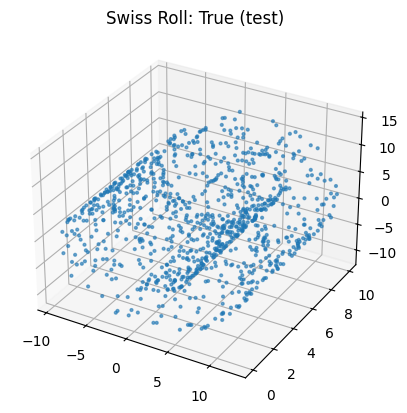

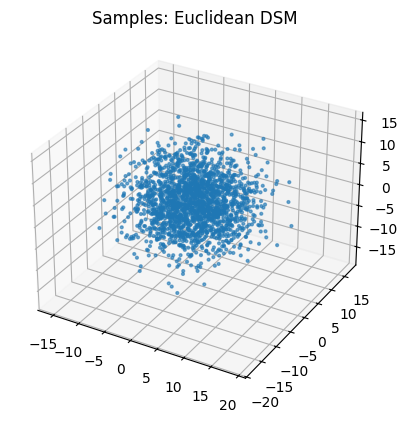

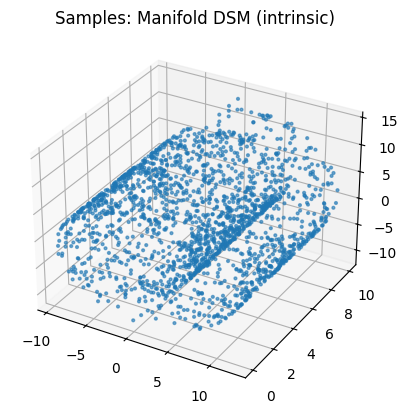

In [10]:
# %% (Optional) quick matplotlib plots
import matplotlib.pyplot as plt

def quick_plot3d(points, title):
    pts = points.detach().cpu().numpy()
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=4, alpha=0.6)
    ax.set_title(title); plt.show()

# True data, Euclidean samples, Manifold samples
quick_plot3d(x_test, "Swiss Roll: True (test)")
quick_plot3d(x_samp_eucl, "Samples: Euclidean DSM")
quick_plot3d(x_samp_manif, "Samples: Manifold DSM (intrinsic)")
